In [1]:
import sparkbeyond._api2.classes as sb
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# For API key
import os

np.random.seed(seed=42)

In [2]:
# Import the needed class from the sampling_toolbox
from sampling_toolbox import PermutationObject, rig
from sparkbeyond_utils import operational_log_number_of_features, get_binned_target, clean_enriched_data

In [3]:
api_key = os.environ['SB_Demo_API_key']
server_url = 'https://demo.sparkbeyond.com/'
client = sb.SparkBeyondClient(base_url=server_url, api_key=api_key, verify_ssl_certificate=False)

Connecting to https://demo.sparkbeyond.com/...
Connected. Server version 1.36.1


In [4]:
def plot_bias(df_metrics, number_of_bins = 20):
    """Function for plotting the bias measured with the test and population (unseen) data"""
    fig, ax = plt.subplots(1,2, figsize = (12,5))

    # Set bins for both plots
    bins = np.linspace(df_metrics['test_bias'].min(), df_metrics['test_bias'].max(), number_of_bins)

    # Test bias
    df_metrics['test_bias'].hist(ax=ax[0], bins = bins)
    ax[0].vlines(x= 0, ymin = 0,ymax = ax[0].get_ylim()[1],color = 'r')
    ax[0].set_xlabel("Train_RIG - Test_RIG")
    ax[0].set_title('Bias (test)')

    # Population bias
    df_metrics['population_bias'].hist(ax=ax[1], bins = bins)
    ax[1].vlines(x= 0, ymin = 0,ymax = ax[1].get_ylim()[1],color = 'r')
    ax[1].set_xlabel("Train_RIG - Population_RIG")
    ax[1].set_title('Bias (population)')

    print('Test bias \t\t= {}'.format(df_metrics['test_bias'].median()))
    print('Population bias \t= {}'.format(df_metrics['population_bias'].median()))

# Part 2 Measure overestimation bias 
## Binary Classification - Lending Club

In [5]:
filepath = './Data/LC_defaults_loanStats_with_random_parition.csv.gz'
df_full = pd.read_csv(filepath)
df_sample = df_full.sample(frac = 0.1, random_state = 42)
df_pop = df_full[~df_full.index.isin(df_sample.index)]
df_sample.shape, df_full.shape, df_pop.shape

((5466, 42), (54655, 42), (49189, 42))

In [6]:
# Target column
target = 'bad_loans'

# Previously run pipeline
proj_name = 'Lending_Club_peter'
revision = 2

model = client.revision(proj_name, revision_id=revision)

In [7]:
######## NEED TO CHANGE THIS FOR EACH PROJECT IF NON-DEFAULT VALUES ARE USED #########

# Change the default settings to match those from the UI
train = client.upload_dataframe(df_sample[df_sample.splitColumn == 'Train'], 
                                project_name = model.project_name,
                                target_path='train.csv.gz',
                                overwrite = True)
train.source.settings.format.use_escaping = True

test = client.upload_dataframe(df_sample[df_sample.splitColumn == 'Test'], 
                               project_name = model.project_name,
                               target_path = 'test.csv.gz', 
                               overwrite = True)
test.source.settings.format.use_escaping = True

population = client.upload_dataframe(df_pop, 
                               project_name = model.project_name,
                               target_path = 'population.csv.gz', 
                               overwrite = True)
population.source.settings.format.use_escaping = True

######################################################################################

EnrichParams = sb.EnrichParams(inputs = [train], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_train_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [test], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_test_enriched = enrich_object.results_dataframe()


EnrichParams = sb.EnrichParams(inputs = [population], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_population_enriched = enrich_object.results_dataframe()


Target filename with dataframe hash is train-72a45a425239b6baa1a63ecceacd05e4.csv.gz
Writing dataframe to temp file /var/folders/z4/ymtx_b595ngcqjv1bwwv9qjh0000gn/T/trainqgr7mwej.csv.gz



Target filename with dataframe hash is test-6c35c3142e0bf0f7b0a6815b2c87dddb.csv.gz
Writing dataframe to temp file /var/folders/z4/ymtx_b595ngcqjv1bwwv9qjh0000gn/T/testzhy_550g.csv.gz



Target filename with dataframe hash is population-ed6ac62a7a9b94a02b27bc6b74b30306.csv.gz
Writing dataframe to temp file /var/folders/z4/ymtx_b595ngcqjv1bwwv9qjh0000gn/T/populationth80ww2g.csv.gz



Job running, started at 2022-03-30 20:03:31.244000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])



Job running, started at 2022-03-30 20:03:44.997000
Finished building new contexts
Job completed: EnrichPredictJobResult(report_filenames=[])



Job running, started at 2022-03-30 20:03:50.295000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])


In [8]:
df_features = model.features()
df_train_enriched = clean_enriched_data(df_train_enriched, df_features, target)
df_test_enriched = clean_enriched_data(df_test_enriched, df_features, target)
df_population_enriched = clean_enriched_data(df_population_enriched, df_features, target)

Y_train = df_train_enriched[target]
Y_test = df_test_enriched[target]
Y_population = df_population_enriched[target]

In [9]:
df_metrics = df_features[['feature', 'RIG', 'support', '% Missing']].copy()

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_train_enriched[feature], Y_train))
df_metrics['train_rig'] = rigs

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_test_enriched[feature], Y_test))
    
df_metrics['test_rig'] = rigs

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_population_enriched[feature], Y_population))
    
df_metrics['population_rig'] = rigs

df_metrics['percent_difference'] = (abs(df_features['RIG'] - df_metrics['train_rig'])/df_metrics['RIG']*100)
df_metrics.sort_values(by = 'percent_difference', ascending=False).head(n=10)

,feature,RIG,support,% Missing,train_rig,test_rig,population_rig,percent_difference
206,upperCaseRatio(desc) inRange (0.0156 to 0.0161),0.003452,84,0.0%,0.002913,0.002732,2.156748e-05,1.561457e+01
172,"The percent of Set(off, faster) in (slidingSub...",0.003580,36,99%,0.003580,0.000012,2.669192e-04,5.383761e-11
138,zipWithIndex(stemmedWordsWithoutCommonTerms(de...,0.004078,92,83%,0.004078,0.000076,1.815481e-04,1.576136e-11
174,35.0 Weeks ago the value of (unemployment_rate...,0.003733,261,73%,0.003733,0.004486,1.128608e-04,1.289573e-11
155,"zipWithIndex(slidingSubsets(desc)) for (have, ...",0.003879,18,96%,0.003879,0.001754,1.260922e-07,1.242180e-11
213,"zipWithIndex(slidingSubsets(desc)) for (high, ...",0.003880,39,98%,0.003880,0.000192,2.049978e-05,1.241923e-11
110,"The percent of Set(to, off, the) in (slidingSu...",0.003880,39,98%,0.003880,0.001484,7.916272e-05,1.241923e-11
113,"The percent of Set(to, this) in (slidingSubset...",0.003880,39,84%,0.003880,0.003163,2.163384e-04,1.241923e-11
208,zipWithIndex(desc) for but inRange (65.5 to 93.5),0.003880,39,91%,0.003880,0.000365,6.463539e-05,1.241923e-11
150,The percent of currently in (desc) inRange (0....,0.004097,82,94%,0.004097,0.000414,3.429212e-04,1.174948e-11


Clean features where I can't get the RIGs to match due to parsing issues

In [10]:
mask = df_metrics['percent_difference'] < 1
df_metrics = df_metrics[mask].reset_index(drop=True)

mask = df_metrics['percent_difference'] < 1
mask.value_counts()

True    299
Name: percent_difference, dtype: int64

Test bias 		= 0.003333167439018554
Population bias 	= 0.003858860112306103


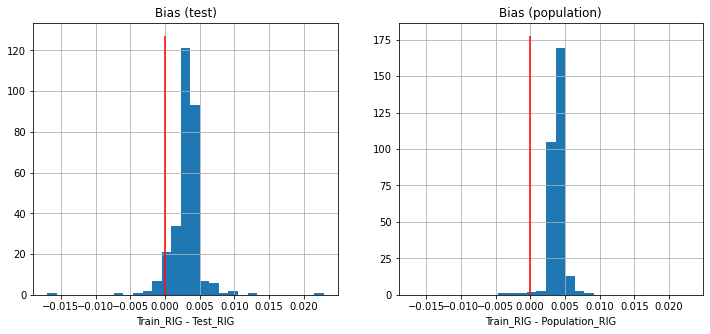

In [11]:
df_metrics['test_bias'] = df_metrics['train_rig'] - df_metrics['test_rig']
df_metrics['population_bias'] = df_metrics['train_rig'] - df_metrics['population_rig']

plot_bias(df_metrics, number_of_bins = 30)

## Regression - King County

In [14]:
df_full = pd.read_csv('./Data/KingCountyHouseSales_with_random_parition_column.csv.gz')
df_sample = df_full.sample(frac = 0.25, random_state = 42 )
df_pop = df_full[~df_full.index.isin(df_sample.index)]
df_sample.shape, df_full.shape, df_pop.shape

((5402, 20), (21610, 20), (16208, 20))

In [15]:
model = client.revision(project_name = 'King_County_Bias_test', revision_id = 7)
target = 'price'

In [16]:
EnrichParams = sb.EnrichParams(inputs = [df_sample[df_sample.splitColumn == 'Train']], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_train_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [df_sample[df_sample.splitColumn == 'Test']], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_test_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [df_sample[df_sample.splitColumn == 'Train']], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_train_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [df_pop], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_population_enriched = enrich_object.results_dataframe()


Target filename with dataframe hash is dataframe-8ee539cf34536f8e4e9133fd851d2161.tsv.gz
Job running, started at 2022-03-30 20:08:22.511000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])



Target filename with dataframe hash is dataframe-75a2a6d4a9e25bdbf391f58808b3515e.tsv.gz
Job running, started at 2022-03-30 20:08:51.098000
Finished building new contexts
Job completed: EnrichPredictJobResult(report_filenames=[])



Target filename with dataframe hash is dataframe-8ee539cf34536f8e4e9133fd851d2161.tsv.gz
Job running, started at 2022-03-30 20:09:23.081000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])



Target filename with dataframe hash is dataframe-25d2a12f945cf09020d95a3d28eaed9d.tsv.gz
Job running, started at 2022-03-30 20:09:55.601000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])


In [17]:
# Get the features datarame
df_features = model.features()

# Clean the enriched data
df_train_enriched = clean_enriched_data(df_train_enriched, df_features, target)
df_test_enriched = clean_enriched_data(df_test_enriched, df_features, target)
df_population_enriched = clean_enriched_data(df_population_enriched, df_features, target)

# Get the binned target for RIG calculations
Y_train = get_binned_target(df_features, df_train_enriched[target])
Y_test = get_binned_target(df_features, df_test_enriched[target])
Y_population = get_binned_target(df_features, df_population_enriched[target])

[75000, 279000, 359950, 449500, 561500, 750000, 5570000]
[75000, 279000, 359950, 449500, 561500, 750000, 5570000]
[75000, 279000, 359950, 449500, 561500, 750000, 5570000]


In [18]:
# Two features have the same name
df_train_enriched.columns[df_train_enriched.columns.str.contains('does not contain "addr:unit"')]

Index(['on OpenStreetMap, the circle3km around latLong does not contain "addr:unit"', 'on OpenStreetMap, the circle3km around latLong does not contain "addr:unit"_'], dtype='object')

In [19]:
# Change the feature name to match the column name
df_features.loc[240,'booleanFeatureName'] = 'on OpenStreetMap, the circle3km around latLong does not contain "addr:unit"_'

Create the metrics dataframe

In [20]:
df_metrics = df_features[['feature', 'RIG', 'support', '% Missing']].copy()

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_train_enriched[feature], Y_train))
df_metrics['train_rig'] = rigs

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_test_enriched[feature], Y_test))
    
df_metrics['test_rig'] = rigs

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_population_enriched[feature], Y_population))
    
df_metrics['population_rig'] = rigs

# Check Python RIG calculations match DP - Having all values less than 1% is acceptable 
# This calculation is a proxy for consistent file parsing between the platform and the SDK
df_metrics['percent_difference'] = (abs(df_features['RIG'] - df_metrics['train_rig'])/df_metrics['RIG']*100)
df_metrics.sort_values(by = 'percent_difference', ascending = False).head(n = 10)

,feature,RIG,support,% Missing,train_rig,test_rig,population_rig,percent_difference
292,"the number of occurrences of (shop, convenienc...",0.020699,987,7%,0.020864,0.016594,0.017410,0.796537
223,Foreign-Pct of zipcode < 17.75,0.013364,2042,0.0%,0.013446,0.020694,0.013260,0.617323
51,"Males-30-34 of zipcode notInRange (874.5 to 1,...",0.036633,2047,NaN,0.036777,0.030488,0.038060,0.392218
216,Females-30-34 of zipcode < 931,0.023229,1448,NaN,0.023314,0.026881,0.024723,0.363123
249,"Males-35-39 of zipcode inRange (1,013 to 1,526.5)",0.024977,1928,NaN,0.025065,0.023641,0.028616,0.354959
47,"Males-25-29 of zipcode inRange (860.5 to 1,905)",0.037634,1925,NaN,0.037765,0.028757,0.038838,0.349385
286,floor(bathrooms) == 2.0,0.011925,2107,0.0%,0.011884,0.007782,0.012266,0.337254
73,the distance of accountant from latLong accord...,0.015920,1864,53%,0.015973,0.020417,0.018379,0.332933
113,the distance of Pizza Hut from latLong accordi...,0.014757,1656,61%,0.014806,0.014263,0.012231,0.331012
132,Females-85-89 of zipcode >= 202,0.010859,1861,NaN,0.010826,0.007489,0.010180,0.302392


Test bias 		= 0.002597904749907705
Population bias 	= 0.003061118341594997


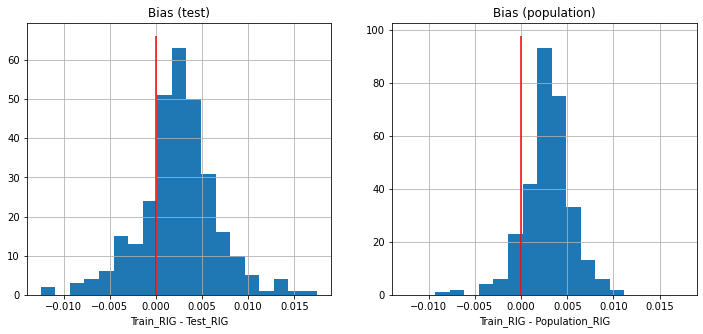

In [21]:
# Calculate the biases
df_metrics['test_bias'] = df_metrics['train_rig'] - df_metrics['test_rig']
df_metrics['population_bias'] = df_metrics['train_rig'] - df_metrics['population_rig']

plot_bias(df_metrics)

In [22]:
df_metrics.corr()

,RIG,support,train_rig,test_rig,population_rig,percent_difference,test_bias,population_bias
RIG,1.000000,0.443032,0.999998,0.977200,0.991037,-0.119952,0.170872,0.167643
support,0.443032,1.000000,0.442984,0.417741,0.471152,0.554112,0.146009,-0.163450
train_rig,0.999998,0.442984,1.000000,0.977226,0.991077,-0.119038,0.170761,0.167357
test_rig,0.977200,0.417741,0.977226,1.000000,0.977477,-0.130135,-0.042213,0.097194
population_rig,0.991037,0.471152,0.991077,0.977477,1.000000,-0.081410,0.127585,0.034453
percent_difference,-0.119952,0.554112,-0.119038,-0.130135,-0.081410,1.000000,0.043787,-0.290389
test_bias,0.170872,0.146009,0.170761,-0.042213,0.127585,0.043787,1.000000,0.336668
population_bias,0.167643,-0.163450,0.167357,0.097194,0.034453,-0.290389,0.336668,1.000000


Just OSM features

Test bias 		= 0.0026215001528212024
Population bias 	= 0.0032267684697485782


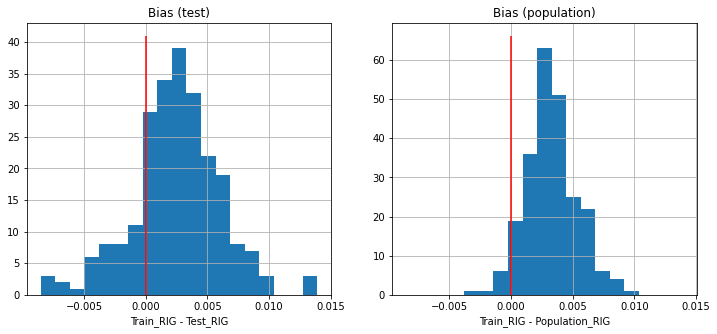

In [23]:
osm_features = df_features[df_features['Context names'] == 'OSM, OpenStreetMap']['feature'].tolist()
plot_bias(df_metrics[df_metrics.feature.isin(osm_features)])

## Estimating the null rig distribution

In [24]:
Y_train.value_counts().sum()

4296

In [25]:
log = '''22:00:06 - Learning to predict (regression) price (revision #7). Evaluating using RMSE
22:00:06 - context data-frames:
22:00:07 - processing context dataframe World Knowledge contextName:World Knowledge
22:00:07 - processing context dataframe -nugl0g9k9brra4odp6zpf76l0f8fvk-census.csv.gz contextName:Census
22:00:07 - context dataframe -nugl0g9k9brra4odp6zpf76l0f8fvk-census.csv.gz matched generator 'Lookup'
22:00:07 - detected world knowledge context:
DataFrame(World Knowledge)
22:00:32 - Best feature (RIG: 0.0027) of 1 from waterfront is: waterfront == 1
22:00:32 - Best feature (RIG: 0.0049) of 1 from date is: dayOfMonth(date) < 8
22:00:32 - Best feature (RIG: 0.004) of 6 from condition is: condition == 4
22:00:32 - Best feature (RIG: 0.0261) of 5 from view is: view >= 1
22:00:32 - Best feature (RIG: 0.0266) of 5 from floors is: floors < 1.25
22:00:32 - Best feature (RIG: 0.1002) of 1 from grade is: cbrt(grade) >= 2.04
22:00:32 - Best feature (RIG: 0.0117) of 2 from sqft_lot is: log(sqft_lot) < 8.548
22:00:32 - Best feature (RIG: 0.0701) of 1 from sqft_above is: sqft_above >= 2055
22:00:32 - Best feature (RIG: 0.0117) of 1 from sqft_lot is: log10(sqft_lot) < 3.712
22:00:32 - Best feature (RIG: 0.0989) of 1 from sqft_living is: log1p(sqft_living) >= 7.742
22:00:32 - Best feature (RIG: 0.0989) of 1 from sqft_living is: toDouble(sqft_living) >= 2303.0
22:00:32 - Best feature (RIG: 0.0989) of 2 from sqft_living is: sqft_living >= 2303
22:00:32 - Best feature (RIG: 0.0262) of 10 from bedrooms is: bedrooms >= 4
22:00:32 - Best feature (RIG: 0.0701) of 2 from sqft_above is: toDouble(sqft_above) >= 2055.0
22:00:32 - Best feature (RIG: 0.0262) of 9 from bedrooms is: inverse(bedrooms) < 0.292
22:00:32 - Best feature (RIG: 0.0044) of 13 from date is: getMonth(date) inRange (7 to 8)
22:00:32 - Best feature (RIG: 0.0701) of 1 from sqft_above is: cubed(sqft_above) >= 8.6784705E9
22:00:32 - Best feature (RIG: 0.1002) of 11 from grade is: arithmeticNot(grade) < -7.5
22:00:32 - Best feature (RIG: 0.0509) of 9 from bathrooms is: exp(bathrooms) >= 10.835
22:00:32 - Best feature (RIG: 0.1002) of 12 from grade is: grade >= 9
22:00:32 - Best feature (RIG: 0.0262) of 9 from bedrooms is: relu(bedrooms) >= 3.5
22:00:32 - Best feature (RIG: 0.0213) of 1 from sqft_basement is: sqft_basement >= 785
22:00:32 - Best feature (RIG: 0.0509) of 27 from bathrooms is: roundToInt(bathrooms) >= 3
22:00:32 - Best feature (RIG: 0.0262) of 9 from bedrooms is: toDouble(bedrooms) >= 3.5
22:00:32 - Best feature (RIG: 0.0213) of 2 from sqft_basement is: squared(sqft_basement) >= 616250.0
22:00:32 - Best feature (RIG: 0.0117) of 1 from sqft_lot is: cbrt(sqft_lot) < 17.277
22:00:32 - Best feature (RIG: 0.0989) of 1 from sqft_living is: squared(sqft_living) >= 5303813.0
22:00:32 - Best feature (RIG: 0.003) of 1 from yr_renovated is: sigmoid(yr_renovated) != 0.5
22:00:32 - Best feature (RIG: 0.0701) of 1 from sqft_above is: squared(sqft_above) >= 4223050.0
22:00:32 - Best feature (RIG: 0.0213) of 3 from sqft_basement is: |sqft_basement| >= 785
22:00:32 - Best feature (RIG: 0.0137) of 2 from yr_built is: |yr_built| notInRange (1,917 to 1,998)
22:00:32 - Best feature (RIG: 0.0509) of 32 from bathrooms is: cubed(bathrooms) >= 13.508
22:00:32 - Best feature (RIG: 0.0137) of 2 from yr_built is: sqrt(yr_built) notInRange (43.78 to 44.7)
22:00:32 - Best feature (RIG: 0.0213) of 2 from sqft_basement is: reluHalf(sqft_basement) >= 785.0
22:00:32 - Best feature (RIG: 0.0137) of 2 from yr_built is: yr_built notInRange (1,917 to 1,998)
22:00:32 - Best feature (RIG: 0.0117) of 1 from sqft_lot is: sqft_lot < 5157
22:00:32 - Best feature (RIG: 0.0137) of 3 from yr_built is: toDouble(yr_built) notInRange (1,916.5 to 1,998.5)
22:00:32 - Best feature (RIG: 0.0062) of 1 from yr_renovated is: cbrt(yr_renovated) >= 12.573
22:00:32 - Best feature (RIG: 0.1002) of 11 from grade is: squared(grade) >= 72.5
22:00:32 - Best feature (RIG: 0.0062) of 2 from yr_renovated is: yr_renovated >= 1988
22:00:32 - Best feature (RIG: 0.0062) of 2 from yr_renovated is: |yr_renovated| >= 1988
22:00:32 - Best feature (RIG: 0.0509) of 27 from bathrooms is: squared(bathrooms) >= 5.656
22:00:32 - Best feature (RIG: 0.0059) of 70 from date is: dateToDouble(date) inRange (2014.05.07 12:00, 2014.05.15 12:00)
22:00:33 - Best feature (RIG: 0.0436) of 2 from zipcode is: College-Pct of zipcode inRange (17 to 28)
22:00:33 - Best feature (RIG: 0.0347) of 1 from zipcode is: HU-LP-Gas of zipcode >= 326
22:00:33 - Best feature (RIG: 0.0202) of 2 from zipcode is: HU-Occupied of zipcode notInRange (8,269.5 to 19,776)
22:00:33 - Best feature (RIG: 0.0269) of 2 from zipcode is: Males-10-14 of zipcode >= 927
22:00:33 - Best feature (RIG: 0.0953) of 3 from zipcode is: Black of zipcode >= 1304
22:00:33 - Best feature (RIG: 0.0098) of 1 from zipcode is: HU-Other of zipcode < 3
22:00:33 - Best feature (RIG: 0.0336) of 4 from zipcode is: Females-30-34 of zipcode notInRange (985 to 1,934)
22:00:33 - Best feature (RIG: 0.013) of 13 from zipcode is: HU-Coal of zipcode inRange (3 to 13.5)
22:00:33 - Best feature (RIG: 0.0585) of 4 from zipcode is: HH-Cash-Assist of zipcode < 257
22:00:33 - Best feature (RIG: 0.0304) of 2 from zipcode is: Males-75-79 of zipcode inRange (215 to 343)
22:00:33 - Best feature (RIG: 0.0245) of 2 from zipcode is: Females-60-64 of zipcode inRange (1,184.5 to 1,365.5)
22:00:33 - Best feature (RIG: 0.117) of 3 from zipcode is: Per-Cap-Income of zipcode >= 42179
22:00:33 - Best feature (RIG: 0.0673) of 2 from zipcode is: Other-Race of zipcode < 530
22:00:33 - Best feature (RIG: 0.037) of 3 from zipcode is: Males-25-29 of zipcode inRange (1,079 to 1,432)
22:00:33 - Best feature (RIG: 0.0357) of 4 from zipcode is: Males-5-9 of zipcode inRange (1,354 to 1,836)
22:00:33 - Best feature (RIG: 0.0373) of 2 from zipcode is: Females-25-29 of zipcode notInRange (788 to 1,880)
22:00:33 - Best feature (RIG: 0.0138) of 70 from zipcode is: latLong of zipcode == LatLong(47.62, -122.2)
22:00:33 - Best feature (RIG: 0.0044) of 282 from date is: monthOfYear(date) inRange (8 to 9)
22:00:33 - Best feature (RIG: 0.0265) of 4 from zipcode is: Males-35-39 of zipcode inRange (1,013 to 1,526.5)
22:00:33 - Best feature (RIG: 0.0775) of 3 from zipcode is: HH-Retire-Amt of zipcode >= 25295
22:00:33 - Best feature (RIG: 0.0269) of 4 from zipcode is: Males-80-84 of zipcode notInRange (114.5 to 271)
22:00:33 - Best feature (RIG: 0.0749) of 4 from zipcode is: HH-Earnings-Amt of zipcode >= 95739
22:00:33 - Best feature (RIG: 0.062) of 3 from zipcode is: HH-SSI of zipcode < 289
22:00:33 - Best feature (RIG: 0.0377) of 4 from zipcode is: Males-0-4 of zipcode inRange (1,296 to 1,463.5)
22:00:33 - Best feature (RIG: 0.0383) of 4 from zipcode is: Males-30-34 of zipcode notInRange (941.5 to 1,563.5)
22:00:33 - Best feature (RIG: 0.1422) of 1 from zipcode is: Degree-Pct of zipcode >= 49.8
22:00:33 - Best feature (RIG: 0.1057) of 27 from zipcode is: Hawaiian of zipcode >= 195
22:00:33 - Best feature (RIG: 0.0213) of 4 from zipcode is: HH-Earnings of zipcode inRange (9,441.5 to 10,166.5)
22:00:33 - Best feature (RIG: 0.0239) of 4 from zipcode is: Asian of zipcode inRange (3,705.5 to 4,279)
22:00:33 - Best feature (RIG: 0.0187) of 1 from zipcode is: Land-Area of zipcode < 5
22:00:33 - Best feature (RIG: 0.0628) of 4 from zipcode is: Hispanic of zipcode >= 3070
22:00:33 - Best feature (RIG: 0.076) of 1 from sqft_living15 is: cbrt(sqft_living15) >= 12.976
22:00:33 - Best feature (RIG: 0.0255) of 6 from zipcode is: HH-Retire of zipcode >= 1767
22:00:33 - Best feature (RIG: 0.0533) of 4 from zipcode is: Poverty-Pct of zipcode >= 8.25
22:00:33 - Best feature (RIG: 0.076) of 1 from sqft_living15 is: relu(sqft_living15) >= 2185.0
22:00:33 - Best feature (RIG: 0.1192) of 2 from zipcode is: Family-Avg-Income of zipcode >= 114776
22:00:33 - Best feature (RIG: 0.0239) of 2 from zipcode is: Males-45-49 of zipcode inRange (662 to 749.5)
22:00:33 - Best feature (RIG: 0.1028) of 2 from zipcode is: Family-Med-Income of zipcode >= 103132
22:00:33 - Best feature (RIG: 0.076) of 2 from sqft_living15 is: sqft_living15 >= 2185
22:00:33 - Best feature (RIG: 0.0275) of 2 from zipcode is: Females-80-84 of zipcode inRange (249.5 to 275.5)
22:00:33 - Best feature (RIG: 0.076) of 1 from sqft_living15 is: squared(sqft_living15) >= 4774250.0
22:00:33 - Best feature (RIG: 0.0388) of 1 from zipcode is: Females-15-19 of zipcode >= 934
22:00:33 - Best feature (RIG: 0.0159) of 13 from zipcode is: HU-Solar of zipcode inRange (17.5 to 23)
22:00:33 - Best feature (RIG: 0.0436) of 3 from zipcode is: HH-Med-Income of zipcode >= 82058
22:00:33 - Best feature (RIG: 0.0269) of 3 from zipcode is: HU-Electric of zipcode notInRange (3,175 to 7,677.5)
22:00:33 - Best feature (RIG: 0.015) of 1 from sqft_lot15 is: log10(sqft_lot15) >= 4.062
22:00:33 - Best feature (RIG: 0.048) of 3 from zipcode is: HH-SS-Amt of zipcode >= 19052
22:00:33 - Best feature (RIG: 0.015) of 2 from sqft_lot15 is: sqft_lot15 >= 11546
22:00:33 - Best feature (RIG: 0.015) of 1 from sqft_lot15 is: log1p(sqft_lot15) >= 9.354
22:00:33 - Best feature (RIG: 0.0217) of 5 from zipcode is: HU-1960-1969 of zipcode inRange (182.5 to 474.5)
22:00:33 - Best feature (RIG: 0.1378) of 1 from zipcode is: Avg-Home-Value of zipcode >= 487151
22:00:33 - Best feature (RIG: 0.0543) of 2 from zipcode is: Females-90-Up of zipcode inRange (36.5 to 87)
22:00:33 - Best feature (RIG: 0.015) of 1 from sqft_lot15 is: toDouble(sqft_lot15) >= 11545.5
22:00:33 - Best feature (RIG: 0.0271) of 5 from zipcode is: Not-Hispanic of zipcode inRange (25,390.5 to 41,431.5)
22:00:33 - Best feature (RIG: 0.0457) of 2 from zipcode is: HU-Vacant-Rent of zipcode inRange (215 to 498)
22:00:33 - Best feature (RIG: 0.0504) of 4 from zipcode is: HU-Mobile of zipcode >= 183
22:00:33 - Best feature (RIG: 0.0837) of 7 from zipcode is: HH-Food-Stamps of zipcode >= 908
22:00:33 - Best feature (RIG: 0.0835) of 4 from zipcode is: Family-Size of zipcode >= 3.105
22:00:33 - Best feature (RIG: 0.0799) of 6 from zipcode is: Indian of zipcode >= 220.5
22:00:33 - Best feature (RIG: 0.1334) of 3 from zipcode is: Med-Home-Value of zipcode >= 418100
22:00:33 - Best feature (RIG: 0.0518) of 8 from zipcode is: HU-Wood of zipcode < 50
22:00:33 - Best feature (RIG: 0.0486) of 4 from zipcode is: HH-Size of zipcode < 2.435
22:00:33 - Best feature (RIG: 0.0492) of 74 from zipcode is: HU-Before-1940 of zipcode notInRange (198.5 to 3,878)
22:00:33 - Best feature (RIG: 0.0396) of 8 from zipcode is: Median-Age-F of zipcode notInRange (34.55 to 38.95)
22:00:33 - Best feature (RIG: 0.0138) of 85 from zipcode is: prefixes(zipcode) contains "98004"
22:00:33 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (latLong, zipcode) == (LatLong(47.72, -122.29), "98125")
22:00:33 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (zipcode, circle3km around latLong) == ("98125", GeoCircle(LatLong(47.72, -122.29), 3, com.sparkbeyond.runtime.feature.types.SBLengthUnit.`kilometer`, 100))
22:00:33 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (circle100m around latLong, zipcode) == (GeoCircle(LatLong(47.72, -122.29), 0.1, com.sparkbeyond.runtime.feature.types.SBLengthUnit.`kilometer`, 100), "98125")
22:00:33 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (zipcode, latLong) == ("98125", LatLong(47.72, -122.29))
22:01:28 - Best feature (RIG: 0.1173) of 1000 from latLong is: latitude(latLong) < 47.536
22:02:38 - Best feature (RIG: 0.0546) of 1000 from latLong is: the distance of underground from latLong according to OpenStreetMap < 2.939
22:02:38 - Best feature (RIG: 0.0533) of 1000 from latLong is: on OpenStreetMap, the circle3km around latLong contains "underground"
22:02:42 - Best feature (RIG: 0.0946) of 1000 from latLong is: latLong0(latLong) != LatLong(48, -122)
22:02:42 - stage end, feature generation took 129.5 seconds to this point
22:02:48 - feature generation on 21 column subsets took 129.5 seconds
22:02:48 - Best feature (RIG: 0.0032) of 6 from condition is: condition != 3
22:02:48 - Best feature (RIG: 0.0761) of 1 from sqft_living15 is: cbrt(sqft_living15) >= 12.976
22:02:48 - Best feature (RIG: 7.0E-4) of 1 from date is: dayOfMonth(date) < 14
22:02:48 - Best feature (RIG: 0.0975) of 1 from grade is: cbrt(grade) >= 2.04
22:02:48 - Best feature (RIG: 9.0E-4) of 2 from date is: getMonth(date) == 11
22:02:48 - Best feature (RIG: 0.0975) of 12 from grade is: grade >= 9
22:02:48 - Best feature (RIG: 0.0084) of 1 from sqft_lot is: log10(sqft_lot) >= 4.083
22:02:48 - Best feature (RIG: 0.0761) of 1 from sqft_living15 is: relu(sqft_living15) >= 2185.0
22:02:48 - Best feature (RIG: 0.004) of 1 from waterfront is: waterfront == 1
22:02:48 - Best feature (RIG: 0.0445) of 8 from bathrooms is: exp(bathrooms) < 8.438
22:02:48 - Best feature (RIG: 0.0039) of 1 from yr_renovated is: sigmoid(yr_renovated) >= 0.75
22:02:48 - Best feature (RIG: 0.0084) of 2 from sqft_lot is: log(sqft_lot) >= 9.401
22:02:48 - Best feature (RIG: 0.0284) of 5 from floors is: floors == 1.0
22:02:48 - Best feature (RIG: 0.0271) of 5 from view is: view >= 1
22:02:48 - Best feature (RIG: 0.0975) of 11 from grade is: cubed(grade) >= 620.5
22:02:48 - Best feature (RIG: 0.0063) of 2 from yr_renovated is: yr_renovated >= 1987
22:02:48 - Best feature (RIG: 0.0445) of 8 from bathrooms is: sqrt(bathrooms) < 1.457
22:02:48 - Best feature (RIG: 0.0761) of 1 from sqft_living15 is: squared(sqft_living15) >= 4774250.0
22:02:48 - Best feature (RIG: 0.0063) of 2 from yr_renovated is: |yr_renovated| >= 1987
22:02:48 - Best feature (RIG: 0.0761) of 2 from sqft_living15 is: sqft_living15 >= 2185
22:02:48 - Best feature (RIG: 0.0102) of 2 from sqft_lot15 is: sqft_lot15 >= 10503
22:02:48 - Best feature (RIG: 0.0445) of 11 from bathrooms is: cubed(bathrooms) < 9.695
22:02:48 - Best feature (RIG: 0.0102) of 1 from sqft_lot15 is: log10(sqft_lot15) >= 4.021
22:02:48 - Best feature (RIG: 0.0975) of 11 from grade is: squared(grade) >= 72.5
22:02:48 - Best feature (RIG: 0.0063) of 1 from yr_renovated is: cbrt(yr_renovated) >= 12.571
22:02:48 - Best feature (RIG: 0.0102) of 1 from sqft_lot15 is: log1p(sqft_lot15) >= 9.26
22:02:48 - Best feature (RIG: 0.0015) of 17 from date is: dateToDouble(date) inRange (2014.05.26 12:00, 2014.06.19 12:00)
22:02:48 - Best feature (RIG: 0.098) of 2 from sqft_living is: sqft_living >= 2303
22:02:48 - Best feature (RIG: 0.098) of 1 from sqft_living is: toDouble(sqft_living) >= 2303.0
22:02:48 - Best feature (RIG: 0.0445) of 8 from bathrooms is: bathrooms < 2.125
22:02:48 - Best feature (RIG: 0.0135) of 2 from yr_built is: |yr_built| inRange (1,942 to 1,986)
22:02:48 - Best feature (RIG: 0.0135) of 2 from yr_built is: yr_built inRange (1,942 to 1,986)
22:02:48 - Best feature (RIG: 0.0141) of 3 from yr_built is: inverse(yr_built) notInRange (5.01378823186351E-4 to 5.182690164035703E-4)
22:02:48 - Best feature (RIG: 0.0135) of 2 from yr_built is: sqrt(yr_built) inRange (44.06 to 44.57)
22:02:48 - Best feature (RIG: 0.0328) of 8 from bedrooms is: inverse(bedrooms) < 0.292
22:02:48 - Best feature (RIG: 0.0328) of 8 from bedrooms is: log1p(bedrooms) >= 1.498
22:02:48 - Best feature (RIG: 0.098) of 1 from sqft_living is: log1p(sqft_living) >= 7.742
22:02:48 - Best feature (RIG: 0.0328) of 9 from bedrooms is: bedrooms >= 4
22:02:48 - Best feature (RIG: 0.0672) of 1 from sqft_above is: sqft_above >= 1825
22:02:48 - Best feature (RIG: 0.0014) of 59 from date is: date == Wed Oct 15 00:00:00 UTC 2014
22:02:48 - Best feature (RIG: 0.0084) of 1 from sqft_lot is: log1p(sqft_lot) >= 9.401
22:02:48 - Best feature (RIG: 0.0672) of 2 from sqft_above is: toDouble(sqft_above) >= 1825.0
22:02:48 - Best feature (RIG: 0.0102) of 1 from sqft_lot15 is: toDouble(sqft_lot15) >= 10503.0
22:02:48 - Best feature (RIG: 0.098) of 1 from sqft_living is: squared(sqft_living) >= 5303813.0
22:02:48 - Best feature (RIG: 0.0672) of 1 from sqft_above is: squared(sqft_above) >= 3330650.0
22:02:48 - Best feature (RIG: 0.0672) of 1 from sqft_above is: cubed(sqft_above) >= 6.0785275E9
22:02:48 - Best feature (RIG: 0.0212) of 1 from sqft_basement is: sqft_basement >= 725
22:02:48 - Best feature (RIG: 0.0212) of 2 from sqft_basement is: arithmeticNot(sqft_basement) < -724.0
22:02:48 - Best feature (RIG: 0.0212) of 2 from sqft_basement is: squared(sqft_basement) >= 525650.0
22:02:48 - Best feature (RIG: 0.0328) of 8 from bedrooms is: sqrt(bedrooms) >= 1.866
22:02:48 - Best feature (RIG: 0.0212) of 3 from sqft_basement is: |sqft_basement| >= 725
22:02:48 - Best feature (RIG: 0.0084) of 1 from sqft_lot is: sqft_lot >= 12100
22:02:48 - Best feature (RIG: 0.0228) of 2 from zipcode is: HU-Occupied of zipcode notInRange (8,269.5 to 19,776)
22:02:48 - Best feature (RIG: 0.0254) of 2 from zipcode is: Males-10-14 of zipcode >= 927
22:02:48 - Best feature (RIG: 0.0507) of 2 from zipcode is: College-Pct of zipcode inRange (17 to 28)
22:02:48 - Best feature (RIG: 0.072) of 1 from zipcode is: Other-Race of zipcode < 530
22:02:48 - Best feature (RIG: 0.0973) of 3 from zipcode is: Black of zipcode >= 1304
22:02:48 - Best feature (RIG: 0.0617) of 4 from zipcode is: HH-Cash-Assist of zipcode < 257
22:02:48 - Best feature (RIG: 0.0131) of 13 from zipcode is: HU-Coal of zipcode inRange (3 to 13.5)
22:02:49 - Best feature (RIG: 0.0381) of 2 from zipcode is: Females-25-29 of zipcode notInRange (788 to 2,058.5)
22:02:49 - Best feature (RIG: 0.0273) of 1 from zipcode is: HU-LP-Gas of zipcode >= 326
22:02:49 - Best feature (RIG: 0.0381) of 2 from zipcode is: Males-75-79 of zipcode inRange (215 to 343)
22:02:49 - Best feature (RIG: 0.034) of 4 from zipcode is: Females-30-34 of zipcode notInRange (985 to 1,934)
22:02:49 - Best feature (RIG: 0.0766) of 3 from zipcode is: HH-Earnings-Amt of zipcode >= 95739
22:02:49 - Best feature (RIG: 0.012) of 67 from zipcode is: latLong of zipcode == LatLong(47.62, -122.2)
22:02:49 - Best feature (RIG: 0.0376) of 3 from zipcode is: Males-25-29 of zipcode inRange (860.5 to 1,905)
22:02:49 - Best feature (RIG: 0.0254) of 4 from zipcode is: Males-80-84 of zipcode notInRange (114.5 to 271)
22:02:49 - Best feature (RIG: 0.1193) of 4 from zipcode is: Per-Cap-Income of zipcode >= 42179
22:02:49 - Best feature (RIG: 0.0346) of 3 from zipcode is: Males-5-9 of zipcode inRange (1,354 to 1,836)
22:02:49 - Best feature (RIG: 0.0657) of 3 from zipcode is: HH-SSI of zipcode < 289
22:02:49 - Best feature (RIG: 0.0106) of 1 from zipcode is: HU-Other of zipcode < 3
22:02:49 - Best feature (RIG: 0.0242) of 2 from zipcode is: Females-60-64 of zipcode inRange (1,184.5 to 1,365.5)
22:02:49 - Best feature (RIG: 0.0778) of 3 from zipcode is: HH-Avg-Income of zipcode >= 106346
22:02:49 - Best feature (RIG: 0.0299) of 4 from zipcode is: Tot-Females of zipcode inRange (15,314 to 23,093)
22:02:49 - Best feature (RIG: 0.0348) of 3 from zipcode is: Males-0-4 of zipcode < 792
22:02:49 - Best feature (RIG: 0.0315) of 6 from zipcode is: HH-Retire of zipcode >= 1767
22:02:49 - Best feature (RIG: 0.0208) of 4 from zipcode is: Water-Area of zipcode < 0.35
22:02:49 - Best feature (RIG: 0.1106) of 24 from zipcode is: Hawaiian of zipcode >= 166
22:02:49 - Best feature (RIG: 0.1414) of 1 from zipcode is: Degree-Pct of zipcode >= 50.6
22:02:49 - Best feature (RIG: 0.0269) of 4 from zipcode is: Asian of zipcode inRange (3,705.5 to 4,279)
22:02:49 - Best feature (RIG: 0.0217) of 1 from zipcode is: Land-Area of zipcode < 5
22:02:49 - Best feature (RIG: 0.0653) of 4 from zipcode is: Hispanic of zipcode >= 3070
22:02:49 - Best feature (RIG: 0.0366) of 4 from zipcode is: Males-30-34 of zipcode notInRange (874.5 to 1,563.5)
22:02:49 - Best feature (RIG: 0.1245) of 2 from zipcode is: Family-Avg-Income of zipcode >= 114776
22:02:49 - Best feature (RIG: 0.0179) of 1 from zipcode is: Males-45-49 of zipcode < 1139
22:02:49 - Best feature (RIG: 0.0542) of 4 from zipcode is: Poverty-Pct of zipcode >= 8.25
22:02:49 - Best feature (RIG: 0.0469) of 3 from zipcode is: HH-Med-Income of zipcode >= 81279
22:02:49 - Best feature (RIG: 0.1028) of 3 from zipcode is: Family-Med-Income of zipcode >= 103132
22:02:49 - Best feature (RIG: 0.0253) of 2 from zipcode is: Females-80-84 of zipcode inRange (249.5 to 275.5)
22:02:49 - Best feature (RIG: 0.0197) of 13 from zipcode is: HU-Solar of zipcode inRange (11.5 to 23)
22:02:49 - Best feature (RIG: 0.0192) of 3 from zipcode is: Males-70-74 of zipcode < 289
22:02:49 - Best feature (RIG: 0.0459) of 2 from zipcode is: HU-Vacant-Rent of zipcode inRange (215 to 498)
22:02:49 - Best feature (RIG: 0.0244) of 3 from zipcode is: HU-Electric of zipcode notInRange (3,175 to 11,967)
22:02:49 - Best feature (RIG: 0.0852) of 7 from zipcode is: HH-Food-Stamps of zipcode >= 908
22:02:49 - Best feature (RIG: 0.0398) of 1 from zipcode is: Females-15-19 of zipcode >= 934
22:02:49 - Best feature (RIG: 0.0158) of 1 from zipcode is: Females-90-Up of zipcode < 87
22:02:49 - Best feature (RIG: 0.0313) of 5 from zipcode is: Not-Hispanic of zipcode inRange (25,390.5 to 41,431.5)
22:02:49 - Best feature (RIG: 0.0801) of 7 from zipcode is: Indian of zipcode >= 220.5
22:02:49 - Best feature (RIG: 0.0471) of 4 from zipcode is: HH-Size of zipcode < 2.435
22:02:49 - Best feature (RIG: 0.0455) of 4 from zipcode is: HH-SS-Amt of zipcode notInRange (13,569.5 to 19,052)
22:02:49 - Best feature (RIG: 0.1398) of 1 from zipcode is: Avg-Home-Value of zipcode >= 487151
22:02:49 - Best feature (RIG: 0.0512) of 8 from zipcode is: HU-Wood of zipcode < 50
22:02:49 - Best feature (RIG: 0.1355) of 3 from zipcode is: Med-Home-Value of zipcode >= 418100
22:02:49 - Best feature (RIG: 0.0728) of 4 from zipcode is: Family-Size of zipcode >= 3.105
22:02:49 - Best feature (RIG: 0.0549) of 71 from zipcode is: HU-Before-1940 of zipcode notInRange (101 to 3,878)
22:02:49 - Best feature (RIG: 0.0562) of 4 from zipcode is: HU-Mobile of zipcode < 49
22:02:49 - Best feature (RIG: 0.0342) of 7 from zipcode is: Median-Age-F of zipcode notInRange (34.55 to 39.3)
22:02:49 - Best feature (RIG: 0.0123) of 82 from zipcode is: prefixes(zipcode) contains "9807"
22:05:43 - Best feature (RIG: 0.1145) of 1000 from latLong is: latitude(latLong) < 47.533
22:08:23 - Best feature (RIG: 0.0993) of 1000 from latLong is: latLong0(latLong) != LatLong(48, -122)
22:08:40 - Best feature (RIG: 0.0493) of 1000 from latLong is: on OpenStreetMap, the circle3km around latLong for (tactile_paving, yes) < 2.919
22:09:25 - Best feature (RIG: 0.0491) of 1000 from latLong is: on OpenStreetMap, the circle3km around latLong contains ("tactile_paving", "yes")
22:09:26 - stage end, feature generation took 397.4 seconds to this point
22:09:32 - feature generation on 19 column subsets took 397.4 seconds
22:09:39 - Enriching training set with discovered features...
22:10:04 - Enriched training set contains 307 features
22:10:14 - Building models...
22:10:57 - Model building completed. Test-set RMSE score of best algorithm: 156506.903'''

In [26]:
operational_log_number_of_features(log)

13720

In [27]:
permutation_test = PermutationObject()

permutation_test.set_data_parameters(nrows = 4300, class_weights = [0.2, 0.2, 0.2, 0.2, 0.2])

permutation_test.create_synthetic_data()

In [28]:
%%time
permutation_test.calculate_null_rigs(permutations = 13720)

Max null RIG 		= 0.0017912878458397497
Median null RIG 	= 0.00024152552995304334
1 in 13720 null RIG 	= 0.0016309840304933082
Gain threshold 		= 0.0005
CPU times: user 3min 26s, sys: 1.5 s, total: 3min 27s
Wall time: 3min 28s


In [29]:
permutation_test.null_rigs_comparison()

1935 in 13720 null RIGs greater than 0.0005 threshold


## Without OSM

In [30]:
model = client.revision(project_name = 'King_County_Bias_test', revision_id = 8)
target = 'price'

In [31]:
EnrichParams = sb.EnrichParams(inputs = [df_sample[df_sample.splitColumn == 'Train']], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_train_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [df_sample[df_sample.splitColumn == 'Test']], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_test_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [df_sample[df_sample.splitColumn == 'Train']], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_train_enriched = enrich_object.results_dataframe()

EnrichParams = sb.EnrichParams(inputs = [df_pop], 
                               enforce_boolean_numeric = True,
                              include_target_column_if_present = True)

enrich_object = model.enrich(EnrichParams)
df_population_enriched = enrich_object.results_dataframe()


Target filename with dataframe hash is dataframe-8ee539cf34536f8e4e9133fd851d2161.tsv.gz
Job running, started at 2022-03-30 20:15:16.917000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])



Target filename with dataframe hash is dataframe-75a2a6d4a9e25bdbf391f58808b3515e.tsv.gz
Job running, started at 2022-03-30 20:15:37.646000
Finished building new contexts
Job completed: EnrichPredictJobResult(report_filenames=[])



Target filename with dataframe hash is dataframe-8ee539cf34536f8e4e9133fd851d2161.tsv.gz
Job running, started at 2022-03-30 20:15:41.196000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])



Target filename with dataframe hash is dataframe-25d2a12f945cf09020d95a3d28eaed9d.tsv.gz
Job running, started at 2022-03-30 20:15:47.566000
Finished building new contexts



Job completed: EnrichPredictJobResult(report_filenames=[])


In [32]:
# Get the features datarame
df_features = model.features()

# Clean the enriched data
df_train_enriched = clean_enriched_data(df_train_enriched, df_features, target)
df_test_enriched = clean_enriched_data(df_test_enriched, df_features, target)
df_population_enriched = clean_enriched_data(df_population_enriched, df_features, target)

# Get the binned target for RIG calculations
Y_train = get_binned_target(df_features, df_train_enriched[target])
Y_test = get_binned_target(df_features, df_test_enriched[target])
Y_population = get_binned_target(df_features, df_population_enriched[target])

[75000, 279000, 359950, 449500, 561500, 750000, 5570000]
[75000, 279000, 359950, 449500, 561500, 750000, 5570000]
[75000, 279000, 359950, 449500, 561500, 750000, 5570000]


In [33]:
df_metrics = df_features[['feature', 'RIG', 'support', '% Missing']].copy()

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_train_enriched[feature], Y_train))
df_metrics['train_rig'] = rigs

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_test_enriched[feature], Y_test))
    
df_metrics['test_rig'] = rigs

rigs = []
for feature in df_features.booleanFeatureName:
    rigs.append(rig(df_population_enriched[feature], Y_population))
    
df_metrics['population_rig'] = rigs

# Check Python RIG calculations match DP - Having all values less than 1% is acceptable 
# This calculation is a proxy for consistent file parsing between the platform and the SDK
df_metrics['percent_difference'] = (abs(df_features['RIG'] - df_metrics['train_rig'])/df_metrics['RIG']*100)
df_metrics.sort_values(by = 'percent_difference', ascending=False).head(n=10)

,feature,RIG,support,% Missing,train_rig,test_rig,population_rig,percent_difference
253,floor(bathrooms) == 0.0,0.001502,12,0.0%,0.001447,0.001811,0.001105,3.685656
186,"prefixes(zipcode) contains ""9802""",0.003009,358,0.0%,0.002955,0.002918,0.001827,1.787891
163,bedrooms == 1,0.002820,34,0.0%,0.002770,0.003263,0.001952,1.775599
160,sqft_lot >= 12100,0.008439,838,NaN,0.008498,0.008070,0.010562,0.694571
134,sqft_lot15 >= 10503,0.010221,926,NaN,0.010291,0.009801,0.012671,0.692608
178,condition != 3,0.003152,1498,0.0%,0.003172,0.002829,0.001190,0.632418
55,Foreign-Pct of zipcode < 17.75,0.013364,2042,0.0%,0.013446,0.020694,0.013260,0.617323
158,condition >= 4,0.002597,1462,NaN,0.002612,0.002429,0.000793,0.598438
94,Median-Age-F of zipcode >= 39.3,0.024537,1526,0.0%,0.024678,0.030485,0.029244,0.574392
78,HU-Util-Gas of zipcode < 3985,0.011434,936,NaN,0.011369,0.007748,0.008334,0.569107


In [34]:
mask = df_metrics['percent_difference'] < 1
df_metrics = df_metrics[mask].reset_index(drop=True)

mask = df_metrics['percent_difference'] < 1
mask.value_counts()

True    297
Name: percent_difference, dtype: int64

Test bias 		= 0.0001832546127616243
Population bias 	= 0.0007634183803723599


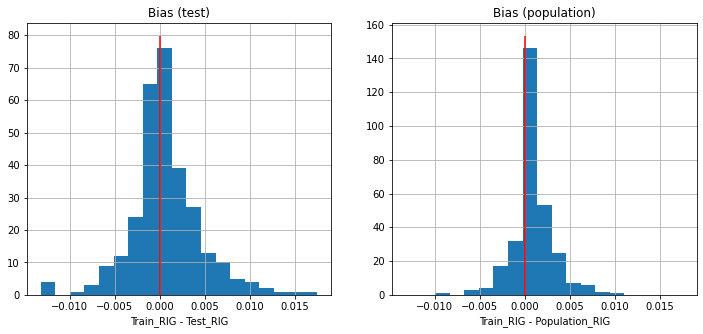

In [35]:
# Calculate the biases
df_metrics['test_bias'] = df_metrics['train_rig'] - df_metrics['test_rig']
df_metrics['population_bias'] = df_metrics['train_rig'] - df_metrics['population_rig']

plot_bias(df_metrics)

In [36]:
1-0.0007634183803723599/0.003061118341594997

0.7506080147249125

In [37]:
log = '''01:29:36 - Learning to predict (regression) price (revision #8). Evaluating using RMSE
01:29:36 - context data-frames:
01:29:37 - processing context dataframe -nugl0g9k9brra4odp6zpf76l0f8fvk-census.csv.gz contextName:Census
01:29:37 - context dataframe -nugl0g9k9brra4odp6zpf76l0f8fvk-census.csv.gz matched generator 'Lookup'
01:30:00 - Best feature (RIG: 0.0027) of 1 from waterfront is: waterfront == 1
01:30:00 - Best feature (RIG: 0.1002) of 1 from grade is: cbrt(grade) >= 2.04
01:30:00 - Best feature (RIG: 0.0261) of 5 from view is: view >= 1
01:30:00 - Best feature (RIG: 0.0049) of 1 from date is: dayOfMonth(date) < 8
01:30:00 - Best feature (RIG: 0.004) of 6 from condition is: condition == 4
01:30:00 - Best feature (RIG: 0.0117) of 1 from sqft_lot is: log10(sqft_lot) < 3.712
01:30:00 - Best feature (RIG: 0.0117) of 2 from sqft_lot is: log(sqft_lot) < 8.548
01:30:00 - Best feature (RIG: 0.0266) of 5 from floors is: floors < 1.25
01:30:00 - Best feature (RIG: 0.0701) of 1 from sqft_above is: sqft_above >= 2055
01:30:00 - Best feature (RIG: 0.1002) of 11 from grade is: arithmeticNot(grade) < -7.5
01:30:00 - Best feature (RIG: 0.0989) of 1 from sqft_living is: log1p(sqft_living) >= 7.742
01:30:00 - Best feature (RIG: 0.0989) of 2 from sqft_living is: sqft_living >= 2303
01:30:00 - Best feature (RIG: 0.0701) of 2 from sqft_above is: toDouble(sqft_above) >= 2055.0
01:30:00 - Best feature (RIG: 0.0989) of 1 from sqft_living is: toDouble(sqft_living) >= 2303.0
01:30:00 - Best feature (RIG: 0.0509) of 9 from bathrooms is: exp(bathrooms) >= 10.835
01:30:00 - Best feature (RIG: 0.0701) of 1 from sqft_above is: cubed(sqft_above) >= 8.6784705E9
01:30:00 - Best feature (RIG: 0.0262) of 10 from bedrooms is: bedrooms >= 4
01:30:00 - Best feature (RIG: 0.0044) of 13 from date is: getMonth(date) inRange (7 to 8)
01:30:00 - Best feature (RIG: 0.0262) of 9 from bedrooms is: inverse(bedrooms) < 0.292
01:30:00 - Best feature (RIG: 0.0213) of 1 from sqft_basement is: sqft_basement >= 785
01:30:00 - Best feature (RIG: 0.0117) of 1 from sqft_lot is: cbrt(sqft_lot) < 17.277
01:30:00 - Best feature (RIG: 0.1002) of 12 from grade is: grade >= 9
01:30:00 - Best feature (RIG: 0.0262) of 9 from bedrooms is: relu(bedrooms) >= 3.5
01:30:00 - Best feature (RIG: 0.0509) of 27 from bathrooms is: roundToInt(bathrooms) >= 3
01:30:00 - Best feature (RIG: 0.0701) of 1 from sqft_above is: squared(sqft_above) >= 4223050.0
01:30:00 - Best feature (RIG: 0.0213) of 2 from sqft_basement is: squared(sqft_basement) >= 616250.0
01:30:00 - Best feature (RIG: 0.003) of 1 from yr_renovated is: sigmoid(yr_renovated) != 0.5
01:30:00 - Best feature (RIG: 0.0989) of 1 from sqft_living is: squared(sqft_living) >= 5303813.0
01:30:00 - Best feature (RIG: 0.0262) of 9 from bedrooms is: toDouble(bedrooms) >= 3.5
01:30:00 - Best feature (RIG: 0.0213) of 3 from sqft_basement is: |sqft_basement| >= 785
01:30:00 - Best feature (RIG: 0.0509) of 32 from bathrooms is: cubed(bathrooms) >= 13.508
01:30:00 - Best feature (RIG: 0.0213) of 2 from sqft_basement is: reluHalf(sqft_basement) >= 785.0
01:30:00 - Best feature (RIG: 0.0137) of 2 from yr_built is: |yr_built| notInRange (1,917 to 1,998)
01:30:00 - Best feature (RIG: 0.0117) of 1 from sqft_lot is: sqft_lot < 5157
01:30:00 - Best feature (RIG: 0.0137) of 2 from yr_built is: sqrt(yr_built) notInRange (43.78 to 44.7)
01:30:00 - Best feature (RIG: 0.0062) of 1 from yr_renovated is: cbrt(yr_renovated) >= 12.573
01:30:00 - Best feature (RIG: 0.0137) of 2 from yr_built is: yr_built notInRange (1,917 to 1,998)
01:30:00 - Best feature (RIG: 0.0137) of 3 from yr_built is: toDouble(yr_built) notInRange (1,916.5 to 1,998.5)
01:30:00 - Best feature (RIG: 0.0062) of 2 from yr_renovated is: yr_renovated >= 1988
01:30:00 - Best feature (RIG: 0.0062) of 2 from yr_renovated is: |yr_renovated| >= 1988
01:30:00 - Best feature (RIG: 0.0059) of 70 from date is: dateToDouble(date) inRange (2014.05.07 12:00, 2014.05.15 12:00)
01:30:00 - Best feature (RIG: 0.0509) of 27 from bathrooms is: squared(bathrooms) >= 5.656
01:30:00 - Best feature (RIG: 0.1002) of 11 from grade is: squared(grade) >= 72.5
01:30:00 - Best feature (RIG: 0.0202) of 2 from zipcode is: HU-Occupied of zipcode notInRange (8,269.5 to 19,776)
01:30:00 - Best feature (RIG: 0.0436) of 2 from zipcode is: College-Pct of zipcode inRange (17 to 28)
01:30:00 - Best feature (RIG: 0.0953) of 3 from zipcode is: Black of zipcode >= 1304
01:30:00 - Best feature (RIG: 0.0336) of 4 from zipcode is: Females-30-34 of zipcode notInRange (985 to 1,934)
01:30:00 - Best feature (RIG: 0.0269) of 2 from zipcode is: Males-10-14 of zipcode >= 927
01:30:00 - Best feature (RIG: 0.0749) of 4 from zipcode is: HH-Earnings-Amt of zipcode >= 95739
01:30:00 - Best feature (RIG: 0.0347) of 1 from zipcode is: HU-LP-Gas of zipcode >= 326
01:30:00 - Best feature (RIG: 0.037) of 3 from zipcode is: Males-25-29 of zipcode inRange (1,079 to 1,432)
01:30:00 - Best feature (RIG: 0.0138) of 70 from zipcode is: latLong of zipcode == LatLong(47.62, -122.2)
01:30:00 - Best feature (RIG: 0.0673) of 2 from zipcode is: Other-Race of zipcode < 530
01:30:00 - Best feature (RIG: 0.0304) of 2 from zipcode is: Males-75-79 of zipcode inRange (215 to 343)
01:30:00 - Best feature (RIG: 0.013) of 13 from zipcode is: HU-Coal of zipcode inRange (3 to 13.5)
01:30:00 - Best feature (RIG: 0.0585) of 4 from zipcode is: HH-Cash-Assist of zipcode < 257
01:30:00 - Best feature (RIG: 0.0098) of 1 from zipcode is: HU-Other of zipcode < 3
01:30:00 - Best feature (RIG: 0.0357) of 4 from zipcode is: Males-5-9 of zipcode inRange (1,354 to 1,836)
01:30:00 - Best feature (RIG: 0.0373) of 2 from zipcode is: Females-25-29 of zipcode notInRange (788 to 1,880)
01:30:00 - Best feature (RIG: 0.117) of 3 from zipcode is: Per-Cap-Income of zipcode >= 42179
01:30:00 - Best feature (RIG: 0.0245) of 2 from zipcode is: Females-60-64 of zipcode inRange (1,184.5 to 1,365.5)
01:30:00 - Best feature (RIG: 0.0265) of 4 from zipcode is: Males-35-39 of zipcode inRange (1,013 to 1,526.5)
01:30:00 - Best feature (RIG: 0.0775) of 3 from zipcode is: HH-Retire-Amt of zipcode >= 25295
01:30:00 - Best feature (RIG: 0.0269) of 4 from zipcode is: Males-80-84 of zipcode notInRange (114.5 to 271)
01:30:00 - Best feature (RIG: 0.0044) of 282 from date is: monthOfYear(date) inRange (8 to 9)
01:30:00 - Best feature (RIG: 0.0213) of 4 from zipcode is: HH-Earnings of zipcode inRange (9,441.5 to 10,166.5)
01:30:00 - Best feature (RIG: 0.1422) of 1 from zipcode is: Degree-Pct of zipcode >= 49.8
01:30:00 - Best feature (RIG: 0.1057) of 27 from zipcode is: Hawaiian of zipcode >= 195
01:30:00 - Best feature (RIG: 0.0383) of 4 from zipcode is: Males-30-34 of zipcode notInRange (941.5 to 1,563.5)
01:30:00 - Best feature (RIG: 0.0377) of 4 from zipcode is: Males-0-4 of zipcode inRange (1,296 to 1,463.5)
01:30:00 - Best feature (RIG: 0.0187) of 1 from zipcode is: Land-Area of zipcode < 5
01:30:00 - Best feature (RIG: 0.062) of 3 from zipcode is: HH-SSI of zipcode < 289
01:30:00 - Best feature (RIG: 0.0239) of 4 from zipcode is: Asian of zipcode inRange (3,705.5 to 4,279)
01:30:00 - Best feature (RIG: 0.0628) of 4 from zipcode is: Hispanic of zipcode >= 3070
01:30:00 - Best feature (RIG: 0.0255) of 6 from zipcode is: HH-Retire of zipcode >= 1767
01:30:00 - Best feature (RIG: 0.076) of 1 from sqft_living15 is: cbrt(sqft_living15) >= 12.976
01:30:00 - Best feature (RIG: 0.1192) of 2 from zipcode is: Family-Avg-Income of zipcode >= 114776
01:30:00 - Best feature (RIG: 0.0533) of 4 from zipcode is: Poverty-Pct of zipcode >= 8.25
01:30:00 - Best feature (RIG: 0.0239) of 2 from zipcode is: Males-45-49 of zipcode inRange (662 to 749.5)
01:30:00 - Best feature (RIG: 0.076) of 1 from sqft_living15 is: relu(sqft_living15) >= 2185.0
01:30:00 - Best feature (RIG: 0.1028) of 2 from zipcode is: Family-Med-Income of zipcode >= 103132
01:30:00 - Best feature (RIG: 0.0159) of 13 from zipcode is: HU-Solar of zipcode inRange (17.5 to 23)
01:30:00 - Best feature (RIG: 0.0436) of 3 from zipcode is: HH-Med-Income of zipcode >= 82058
01:30:00 - Best feature (RIG: 0.0275) of 2 from zipcode is: Females-80-84 of zipcode inRange (249.5 to 275.5)
01:30:00 - Best feature (RIG: 0.0457) of 2 from zipcode is: HU-Vacant-Rent of zipcode inRange (215 to 498)
01:30:00 - Best feature (RIG: 0.0269) of 3 from zipcode is: HU-Electric of zipcode notInRange (3,175 to 7,677.5)
01:30:00 - Best feature (RIG: 0.015) of 1 from sqft_lot15 is: log10(sqft_lot15) >= 4.062
01:30:00 - Best feature (RIG: 0.0388) of 1 from zipcode is: Females-15-19 of zipcode >= 934
01:30:00 - Best feature (RIG: 0.015) of 2 from sqft_lot15 is: sqft_lot15 >= 11546
01:30:00 - Best feature (RIG: 0.048) of 3 from zipcode is: HH-SS-Amt of zipcode >= 19052
01:30:00 - Best feature (RIG: 0.0837) of 7 from zipcode is: HH-Food-Stamps of zipcode >= 908
01:30:00 - Best feature (RIG: 0.076) of 2 from sqft_living15 is: sqft_living15 >= 2185
01:30:00 - Best feature (RIG: 0.076) of 1 from sqft_living15 is: squared(sqft_living15) >= 4774250.0
01:30:00 - Best feature (RIG: 0.015) of 1 from sqft_lot15 is: log1p(sqft_lot15) >= 9.354
01:30:00 - Best feature (RIG: 0.0217) of 5 from zipcode is: HU-1960-1969 of zipcode inRange (182.5 to 474.5)
01:30:00 - Best feature (RIG: 0.0543) of 2 from zipcode is: Females-90-Up of zipcode inRange (36.5 to 87)
01:30:00 - Best feature (RIG: 0.0504) of 4 from zipcode is: HU-Mobile of zipcode >= 183
01:30:00 - Best feature (RIG: 0.0486) of 4 from zipcode is: HH-Size of zipcode < 2.435
01:30:00 - Best feature (RIG: 0.0271) of 5 from zipcode is: Not-Hispanic of zipcode inRange (25,390.5 to 41,431.5)
01:30:00 - Best feature (RIG: 0.1378) of 1 from zipcode is: Avg-Home-Value of zipcode >= 487151
01:30:00 - Best feature (RIG: 0.015) of 1 from sqft_lot15 is: toDouble(sqft_lot15) >= 11545.5
01:30:00 - Best feature (RIG: 0.0835) of 4 from zipcode is: Family-Size of zipcode >= 3.105
01:30:00 - Best feature (RIG: 0.0518) of 8 from zipcode is: HU-Wood of zipcode < 50
01:30:00 - Best feature (RIG: 0.0799) of 6 from zipcode is: Indian of zipcode >= 220.5
01:30:00 - Best feature (RIG: 0.1334) of 3 from zipcode is: Med-Home-Value of zipcode >= 418100
01:30:00 - Best feature (RIG: 0.0492) of 74 from zipcode is: HU-Before-1940 of zipcode notInRange (198.5 to 3,878)
01:30:00 - Best feature (RIG: 0.0396) of 8 from zipcode is: Median-Age-F of zipcode notInRange (34.55 to 38.95)
01:30:01 - Best feature (RIG: 0.0138) of 85 from zipcode is: prefixes(zipcode) contains "98004"
01:30:01 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (latLong, zipcode) == (LatLong(47.72, -122.29), "98125")
01:30:01 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (zipcode, circle3km around latLong) == ("98125", GeoCircle(LatLong(47.72, -122.29), 3, com.sparkbeyond.runtime.feature.types.SBLengthUnit.`kilometer`, 100))
01:30:01 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (circle100m around latLong, zipcode) == (GeoCircle(LatLong(47.72, -122.29), 0.1, com.sparkbeyond.runtime.feature.types.SBLengthUnit.`kilometer`, 100), "98125")
01:30:01 - Best feature (RIG: 0.002) of 1000 from zipcode latLong is: (zipcode, latLong) == ("98125", LatLong(47.72, -122.29))
01:30:02 - Best feature (RIG: 0.1173) of 1000 from latLong is: latitude(latLong) < 47.536
01:30:02 - stage end, feature generation took 2.0 seconds to this point
01:30:04 - feature generation on 21 column subsets took 2.0 seconds
01:30:04 - Best feature (RIG: 0.0975) of 1 from grade is: cbrt(grade) >= 2.04
01:30:04 - Best feature (RIG: 0.004) of 1 from waterfront is: waterfront == 1
01:30:04 - Best feature (RIG: 7.0E-4) of 1 from date is: dayOfMonth(date) < 14
01:30:04 - Best feature (RIG: 0.0761) of 1 from sqft_living15 is: cbrt(sqft_living15) >= 12.976
01:30:04 - Best feature (RIG: 9.0E-4) of 2 from date is: getMonth(date) == 11
01:30:04 - Best feature (RIG: 0.0032) of 6 from condition is: condition != 3
01:30:04 - Best feature (RIG: 0.0284) of 5 from floors is: floors == 1.0
01:30:04 - Best feature (RIG: 0.0761) of 1 from sqft_living15 is: relu(sqft_living15) >= 2185.0
01:30:04 - Best feature (RIG: 0.0039) of 1 from yr_renovated is: sigmoid(yr_renovated) >= 0.75
01:30:04 - Best feature (RIG: 0.0975) of 11 from grade is: cubed(grade) >= 620.5
01:30:04 - Best feature (RIG: 0.0445) of 8 from bathrooms is: exp(bathrooms) < 8.438
01:30:04 - Best feature (RIG: 0.0063) of 1 from yr_renovated is: cbrt(yr_renovated) >= 12.571
01:30:04 - Best feature (RIG: 0.0445) of 8 from bathrooms is: sqrt(bathrooms) < 1.457
01:30:04 - Best feature (RIG: 0.0271) of 5 from view is: view >= 1
01:30:04 - Best feature (RIG: 0.0084) of 1 from sqft_lot is: log10(sqft_lot) >= 4.083
01:30:04 - Best feature (RIG: 0.0084) of 2 from sqft_lot is: log(sqft_lot) >= 9.401
01:30:04 - Best feature (RIG: 0.0063) of 2 from yr_renovated is: |yr_renovated| >= 1987
01:30:04 - Best feature (RIG: 0.0063) of 2 from yr_renovated is: yr_renovated >= 1987
01:30:04 - Best feature (RIG: 0.0975) of 12 from grade is: grade >= 9
01:30:04 - Best feature (RIG: 0.0445) of 11 from bathrooms is: cubed(bathrooms) < 9.695
01:30:04 - Best feature (RIG: 0.0761) of 1 from sqft_living15 is: squared(sqft_living15) >= 4774250.0
01:30:04 - Best feature (RIG: 0.0761) of 2 from sqft_living15 is: sqft_living15 >= 2185
01:30:04 - Best feature (RIG: 0.0102) of 2 from sqft_lot15 is: sqft_lot15 >= 10503
01:30:04 - Best feature (RIG: 0.098) of 1 from sqft_living is: toDouble(sqft_living) >= 2303.0
01:30:04 - Best feature (RIG: 0.0102) of 1 from sqft_lot15 is: log10(sqft_lot15) >= 4.021
01:30:04 - Best feature (RIG: 0.0015) of 17 from date is: dateToDouble(date) inRange (2014.05.26 12:00, 2014.06.19 12:00)
01:30:04 - Best feature (RIG: 0.0135) of 2 from yr_built is: |yr_built| inRange (1,942 to 1,986)
01:30:04 - Best feature (RIG: 0.098) of 2 from sqft_living is: sqft_living >= 2303
01:30:04 - Best feature (RIG: 0.0135) of 2 from yr_built is: sqrt(yr_built) inRange (44.06 to 44.57)
01:30:04 - Best feature (RIG: 0.0445) of 8 from bathrooms is: bathrooms < 2.125
01:30:04 - Best feature (RIG: 0.0102) of 1 from sqft_lot15 is: log1p(sqft_lot15) >= 9.26
01:30:04 - Best feature (RIG: 0.098) of 1 from sqft_living is: log1p(sqft_living) >= 7.742
01:30:04 - Best feature (RIG: 0.0328) of 9 from bedrooms is: bedrooms >= 4
01:30:04 - Best feature (RIG: 0.0084) of 1 from sqft_lot is: log1p(sqft_lot) >= 9.401
01:30:04 - Best feature (RIG: 0.0672) of 1 from sqft_above is: sqft_above >= 1825
01:30:04 - Best feature (RIG: 0.0135) of 2 from yr_built is: yr_built inRange (1,942 to 1,986)
01:30:04 - Best feature (RIG: 0.0328) of 8 from bedrooms is: inverse(bedrooms) < 0.292
01:30:04 - Best feature (RIG: 0.0672) of 1 from sqft_above is: cubed(sqft_above) >= 6.0785275E9
01:30:04 - Best feature (RIG: 0.0141) of 3 from yr_built is: inverse(yr_built) notInRange (5.01378823186351E-4 to 5.182690164035703E-4)
01:30:04 - Best feature (RIG: 0.0975) of 11 from grade is: squared(grade) >= 72.5
01:30:04 - Best feature (RIG: 0.0672) of 2 from sqft_above is: toDouble(sqft_above) >= 1825.0
01:30:04 - Best feature (RIG: 0.0212) of 1 from sqft_basement is: sqft_basement >= 725
01:30:04 - Best feature (RIG: 0.0212) of 2 from sqft_basement is: squared(sqft_basement) >= 525650.0
01:30:04 - Best feature (RIG: 0.0672) of 1 from sqft_above is: squared(sqft_above) >= 3330650.0
01:30:04 - Best feature (RIG: 0.0102) of 1 from sqft_lot15 is: toDouble(sqft_lot15) >= 10503.0
01:30:04 - Best feature (RIG: 0.0014) of 59 from date is: date == Wed Oct 15 00:00:00 UTC 2014
01:30:04 - Best feature (RIG: 0.0328) of 8 from bedrooms is: log1p(bedrooms) >= 1.498
01:30:04 - Best feature (RIG: 0.098) of 1 from sqft_living is: squared(sqft_living) >= 5303813.0
01:30:04 - Best feature (RIG: 0.0212) of 3 from sqft_basement is: |sqft_basement| >= 725
01:30:04 - Best feature (RIG: 0.0212) of 2 from sqft_basement is: arithmeticNot(sqft_basement) < -724.0
01:30:04 - Best feature (RIG: 0.0328) of 8 from bedrooms is: sqrt(bedrooms) >= 1.866
01:30:04 - Best feature (RIG: 0.0084) of 1 from sqft_lot is: sqft_lot >= 12100
01:30:04 - Best feature (RIG: 0.0973) of 3 from zipcode is: Black of zipcode >= 1304
01:30:04 - Best feature (RIG: 0.0254) of 2 from zipcode is: Males-10-14 of zipcode >= 927
01:30:04 - Best feature (RIG: 0.0228) of 2 from zipcode is: HU-Occupied of zipcode notInRange (8,269.5 to 19,776)
01:30:04 - Best feature (RIG: 0.0507) of 2 from zipcode is: College-Pct of zipcode inRange (17 to 28)
01:30:04 - Best feature (RIG: 0.072) of 1 from zipcode is: Other-Race of zipcode < 530
01:30:04 - Best feature (RIG: 0.0273) of 1 from zipcode is: HU-LP-Gas of zipcode >= 326
01:30:04 - Best feature (RIG: 0.0131) of 13 from zipcode is: HU-Coal of zipcode inRange (3 to 13.5)
01:30:04 - Best feature (RIG: 0.0617) of 4 from zipcode is: HH-Cash-Assist of zipcode < 257
01:30:05 - Best feature (RIG: 0.0376) of 3 from zipcode is: Males-25-29 of zipcode inRange (860.5 to 1,905)
01:30:05 - Best feature (RIG: 0.0766) of 3 from zipcode is: HH-Earnings-Amt of zipcode >= 95739
01:30:05 - Best feature (RIG: 0.034) of 4 from zipcode is: Females-30-34 of zipcode notInRange (985 to 1,934)
01:30:05 - Best feature (RIG: 0.0242) of 2 from zipcode is: Females-60-64 of zipcode inRange (1,184.5 to 1,365.5)
01:30:05 - Best feature (RIG: 0.0381) of 2 from zipcode is: Males-75-79 of zipcode inRange (215 to 343)
01:30:05 - Best feature (RIG: 0.0106) of 1 from zipcode is: HU-Other of zipcode < 3
01:30:05 - Best feature (RIG: 0.0346) of 3 from zipcode is: Males-5-9 of zipcode inRange (1,354 to 1,836)
01:30:05 - Best feature (RIG: 0.0778) of 3 from zipcode is: HH-Avg-Income of zipcode >= 106346
01:30:05 - Best feature (RIG: 0.012) of 67 from zipcode is: latLong of zipcode == LatLong(47.62, -122.2)
01:30:05 - Best feature (RIG: 0.0299) of 4 from zipcode is: Tot-Females of zipcode inRange (15,314 to 23,093)
01:30:05 - Best feature (RIG: 0.0381) of 2 from zipcode is: Females-25-29 of zipcode notInRange (788 to 2,058.5)
01:30:05 - Best feature (RIG: 0.0254) of 4 from zipcode is: Males-80-84 of zipcode notInRange (114.5 to 271)
01:30:05 - Best feature (RIG: 0.1193) of 4 from zipcode is: Per-Cap-Income of zipcode >= 42179
01:30:05 - Best feature (RIG: 0.0348) of 3 from zipcode is: Males-0-4 of zipcode < 792
01:30:05 - Best feature (RIG: 0.1414) of 1 from zipcode is: Degree-Pct of zipcode >= 50.6
01:30:05 - Best feature (RIG: 0.0657) of 3 from zipcode is: HH-SSI of zipcode < 289
01:30:05 - Best feature (RIG: 0.0269) of 4 from zipcode is: Asian of zipcode inRange (3,705.5 to 4,279)
01:30:05 - Best feature (RIG: 0.1106) of 24 from zipcode is: Hawaiian of zipcode >= 166
01:30:05 - Best feature (RIG: 0.0208) of 4 from zipcode is: Water-Area of zipcode < 0.35
01:30:05 - Best feature (RIG: 0.0653) of 4 from zipcode is: Hispanic of zipcode >= 3070
01:30:05 - Best feature (RIG: 0.0217) of 1 from zipcode is: Land-Area of zipcode < 5
01:30:05 - Best feature (RIG: 0.0366) of 4 from zipcode is: Males-30-34 of zipcode notInRange (874.5 to 1,563.5)
01:30:05 - Best feature (RIG: 0.0315) of 6 from zipcode is: HH-Retire of zipcode >= 1767
01:30:05 - Best feature (RIG: 0.0542) of 4 from zipcode is: Poverty-Pct of zipcode >= 8.25
01:30:05 - Best feature (RIG: 0.1245) of 2 from zipcode is: Family-Avg-Income of zipcode >= 114776
01:30:05 - Best feature (RIG: 0.1028) of 3 from zipcode is: Family-Med-Income of zipcode >= 103132
01:30:05 - Best feature (RIG: 0.0179) of 1 from zipcode is: Males-45-49 of zipcode < 1139
01:30:05 - Best feature (RIG: 0.0398) of 1 from zipcode is: Females-15-19 of zipcode >= 934
01:30:05 - Best feature (RIG: 0.0244) of 3 from zipcode is: HU-Electric of zipcode notInRange (3,175 to 11,967)
01:30:05 - Best feature (RIG: 0.0158) of 1 from zipcode is: Females-90-Up of zipcode < 87
01:30:05 - Best feature (RIG: 0.0469) of 3 from zipcode is: HH-Med-Income of zipcode >= 81279
01:30:05 - Best feature (RIG: 0.0253) of 2 from zipcode is: Females-80-84 of zipcode inRange (249.5 to 275.5)
01:30:05 - Best feature (RIG: 0.0192) of 3 from zipcode is: Males-70-74 of zipcode < 289
01:30:05 - Best feature (RIG: 0.1398) of 1 from zipcode is: Avg-Home-Value of zipcode >= 487151
01:30:05 - Best feature (RIG: 0.0197) of 13 from zipcode is: HU-Solar of zipcode inRange (11.5 to 23)
01:30:05 - Best feature (RIG: 0.0852) of 7 from zipcode is: HH-Food-Stamps of zipcode >= 908
01:30:05 - Best feature (RIG: 0.0801) of 7 from zipcode is: Indian of zipcode >= 220.5
01:30:05 - Best feature (RIG: 0.0459) of 2 from zipcode is: HU-Vacant-Rent of zipcode inRange (215 to 498)
01:30:05 - Best feature (RIG: 0.0728) of 4 from zipcode is: Family-Size of zipcode >= 3.105
01:30:05 - Best feature (RIG: 0.0471) of 4 from zipcode is: HH-Size of zipcode < 2.435
01:30:05 - Best feature (RIG: 0.0512) of 8 from zipcode is: HU-Wood of zipcode < 50
01:30:05 - Best feature (RIG: 0.0562) of 4 from zipcode is: HU-Mobile of zipcode < 49
01:30:05 - Best feature (RIG: 0.0313) of 5 from zipcode is: Not-Hispanic of zipcode inRange (25,390.5 to 41,431.5)
01:30:05 - Best feature (RIG: 0.1355) of 3 from zipcode is: Med-Home-Value of zipcode >= 418100
01:30:05 - Best feature (RIG: 0.0455) of 4 from zipcode is: HH-SS-Amt of zipcode notInRange (13,569.5 to 19,052)
01:30:05 - Best feature (RIG: 0.0549) of 71 from zipcode is: HU-Before-1940 of zipcode notInRange (101 to 3,878)
01:30:05 - Best feature (RIG: 0.0342) of 7 from zipcode is: Median-Age-F of zipcode notInRange (34.55 to 39.3)
01:30:05 - Best feature (RIG: 0.0123) of 82 from zipcode is: prefixes(zipcode) contains "9807"
01:30:12 - Best feature (RIG: 0.1145) of 417 from latLong is: latitude(latLong) < 47.533
01:30:12 - stage end, feature generation took 8.3 seconds to this point
01:30:14 - feature generation on 19 column subsets took 8.3 seconds
01:30:21 - Enriching training set with discovered features...
01:30:24 - Enriched training set contains 302 features
01:30:32 - Building models...
01:31:07 - Model building completed. Test-set RMSE score of best algorithm: 154114.048'''

In [38]:
operational_log_number_of_features(log)

7137

In [39]:
%%time
permutation_test.calculate_null_rigs(permutations = 7137)

Max null RIG 		= 0.0018530564772717198
Median null RIG 	= 0.00024242144228377033
1 in 7137 null RIG 	= 0.0016054225107349103
Gain threshold 		= 0.0005
CPU times: user 1min 55s, sys: 1.27 s, total: 1min 56s
Wall time: 2min 2s
